<a href="https://colab.research.google.com/github/jimtoberfest/options_notebooks/blob/main/synthetic_variance_swap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#installs and imports

In [1]:
!pip install yfinance -q
!pip install opstrat -q

     |████████████████████████████████| 62 kB 325 kB/s 
     |████████████████████████████████| 6.4 MB 12.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import opstrat as op


#Stock / Options Chain Download

In [3]:
upst = yf.Ticker("UPST")

In [6]:
upst_hist = upst.history(period="1d")
upst_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-12-31,153.229996,156.899994,151.070007,151.300003,2543200,0,0


##Set underlying Price Variable

In [7]:
#underlying Price

S = upst_hist.iloc[0]['Close']
S

151.3000030517578

#build OTM Options Chain

In [8]:
upst_expiries = upst.options

upst.opt = upst.option_chain(upst_expiries[3])

In [9]:
puts_otm = upst.opt.puts[upst.opt.puts['strike']<= S]
puts_otm['type'] = 'p'
calls_otm = upst.opt.calls[upst.opt.calls['strike']>= S]
calls_otm['type'] = 'c'

In [10]:
options_list = [puts_otm,calls_otm]
options_final = pd.concat(options_list)

In [11]:
options_final['mid'] = ((options_final['ask'] - options_final['bid']) / 2) + options_final['bid']


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,type,mid,weighted_K
0,UPST220128P00075000,2021-12-21 16:41:40+00:00,75.0,0.65,0.0,0.3,0.0,0.0,1.0,3,1.136723,False,REGULAR,USD,p,0.15,8.888889
1,UPST220128P00080000,2021-12-27 15:41:47+00:00,80.0,0.27,0.0,0.3,0.0,0.0,1.0,1,1.041020,False,REGULAR,USD,p,0.15,7.812500


#Determine Strike Weights

In [27]:
# Weighting of the Strikes according to:   K_wt =(c / K^2)


options_final['weighted_K'] = 50000 / (options_final['strike']**2)

options_final.head(2)

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,type,mid,weighted_K,calc_value,delta,gamma,theta,vega,dollar_gamma
0,UPST220128P00075000,2021-12-21 16:41:40+00:00,75.0,0.65,0.0,0.3,0.0,0.0,1.0,3,1.136723,False,REGULAR,USD,p,0.15,8.888889,0.148251,-0.008450,0.000483,-0.019524,0.009638,0.110522
1,UPST220128P00080000,2021-12-27 15:41:47+00:00,80.0,0.27,0.0,0.3,0.0,0.0,1.0,1,1.041020,False,REGULAR,USD,p,0.15,7.812500,0.148174,-0.009213,0.000569,-0.019284,0.010397,0.130186


In [28]:
# bsm=op.black_scholes(K=135, St=S, r=1.01, t=28, 
#                      v=81, type=type)
# bsm['value']['option value']
# bsm

In [15]:
# options_final['calc_value'] = options_final.apply(lambda x: bsm(x['strike'], S, 1.01, 28, x['impliedVolatility'],x['type']),axis=1)

#Calculate Greeks; Static Price, Vol, DTE

In [16]:
# S = upst_hist.iloc[0]['Close']

values = []
delta = []
gamma = []
theta = []
vega = []

for i in range(len(options_final)):
  K = options_final.iloc[i]['strike']
  St = S
  r = 1.01
  t = 28
  v = options_final.iloc[i]['impliedVolatility']
  type = options_final.iloc[i]['type']
  
  # print("inputs: ", K, St, r, t, v, type)

  n = op.black_scholes(K=K, St=S, r=r, t=t, 
                     v=v*100, type=type)

  val = n['value']['option value']
  de = n['greeks']['delta']
  ga = n['greeks']['gamma']
  th = n['greeks']['theta']
  ve = n['greeks']['vega']
  
  
  
  values.append(val)
  delta.append(de)
  gamma.append(ga)
  theta.append(th)
  vega.append(ve)


In [17]:
options_final['calc_value'] = values
options_final['delta'] = delta
options_final['gamma'] = gamma
options_final['theta'] = theta
options_final['vega'] = vega
options_final['dollar_gamma'] = (options_final['gamma']/100) * S**2

In [18]:
options_final.head(3)

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,type,mid,weighted_K,calc_value,delta,gamma,theta,vega,dollar_gamma
0,UPST220128P00075000,2021-12-21 16:41:40+00:00,75.0,0.65,0.0,0.30,0.0,0.0,1.0,3,1.136723,False,REGULAR,USD,p,0.150,8.888889,0.148251,-0.008450,0.000483,-0.019524,0.009638,0.110522
1,UPST220128P00080000,2021-12-27 15:41:47+00:00,80.0,0.27,0.0,0.30,0.0,0.0,1.0,1,1.041020,False,REGULAR,USD,p,0.150,7.812500,0.148174,-0.009213,0.000569,-0.019284,0.010397,0.130186
2,UPST220128P00085000,2021-12-30 18:13:06+00:00,85.0,0.17,0.0,0.35,0.0,0.0,1.0,2,0.972657,False,REGULAR,USD,p,0.175,6.920415,0.173883,-0.011364,0.000731,-0.021632,0.012485,0.167323


#Select Strikes for Synth Var Swap (Manual)

In [19]:
K_select = [90,110,130,150,170,190,210,230]

In [20]:
v_ops = options_final[options_final['strike'].isin(K_select)]
v_ops['wt_K'] = round(v_ops['weighted_K'])

#Calc Position Greeks

In [21]:
v_ops['pos_delta'] = v_ops['delta'] * v_ops['wt_K'] * -1
v_ops['pos_gamma'] = v_ops['gamma'] * v_ops['wt_K'] * -1
v_ops['pos_theta'] = v_ops['theta'] * v_ops['wt_K'] * -1
v_ops['pos_vega'] = v_ops['vega'] * v_ops['wt_K'] * -1
v_ops['pos_dollar_gamma'] = v_ops['dollar_gamma'] * v_ops['wt_K']

v_ops['pos_premium'] = v_ops['calc_value'] * v_ops['wt_K']

In [29]:
v_ops.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,type,mid,weighted_K,calc_value,delta,gamma,theta,vega,dollar_gamma,wt_K,pos_delta,pos_gamma,pos_theta,pos_vega,pos_dollar_gamma,pos_premium
3,UPST220128P00090000,2021-12-29 19:58:23+00:00,90.0,0.49,0.10,0.45,0.00,0.000000,1.0,20,0.949219,False,REGULAR,USD,p,0.275,6.172840,0.273712,-0.017419,0.001082,-0.030496,0.018039,0.247732,6.0,0.104517,-0.006493,0.182978,-0.108234,1.486390,1.642273
7,UPST220128P00110000,2021-12-31 18:08:51+00:00,110.0,0.90,0.85,1.20,-0.07,-7.216500,8.0,72,0.812990,False,REGULAR,USD,p,1.025,4.132231,1.016026,-0.062792,0.003623,-0.074801,0.051724,0.829365,4.0,0.251167,-0.014492,0.299204,-0.206898,3.317459,4.064105
11,UPST220128P00130000,2021-12-31 20:11:34+00:00,130.0,4.38,4.10,5.30,0.18,4.285722,14.0,74,0.813112,False,REGULAR,USD,p,4.700,2.958580,4.671392,-0.214828,0.008571,-0.176676,0.122387,1.962096,3.0,0.644485,-0.025714,0.530027,-0.367161,5.886287,14.014175
15,UPST220128P00150000,2021-12-31 20:11:34+00:00,150.0,12.01,12.20,13.40,-0.99,-7.615383,10.0,80,0.809084,False,REGULAR,USD,p,12.800,2.222222,12.738451,-0.438800,0.011628,-0.236502,0.165208,2.661780,2.0,0.877601,-0.023255,0.473003,-0.330416,5.323561,25.476902
14,UPST220128C00170000,2021-12-31 20:58:43+00:00,170.0,7.10,6.30,7.70,-4.69,-39.779476,12.0,74,0.817751,False,REGULAR,USD,c,7.000,1.730104,7.035354,0.345371,0.010756,-0.226802,0.154458,2.462207,2.0,-0.690742,-0.021512,0.453604,-0.308916,4.924415,14.070708


In [23]:
print("  delta: ",v_ops['pos_delta'].sum()*100,'\n',
' gamma: ',v_ops['pos_gamma'].sum()*100,'\n',
' theta: ',v_ops['pos_theta'].sum()*100,'\n',
'  vega: ', v_ops['pos_vega'].sum()*100, '\n',
'$gamma:', v_ops['pos_dollar_gamma'].sum())


  delta:  82.53728230168278 
  gamma:  -10.748991360538035 
  theta:  231.2090993144475 
   vega:  -156.36592763849347 
 $gamma: 24.606258796439917


In [24]:
v_ops['pos_premium'].sum()*100

6527.990535274813

#Graph Terminal Payout Risk (manual)

In [30]:
6,4,3,2,2,1,1,1   #how many of each strike

(6, 4, 3, 2, 2, 1, 1, 1)

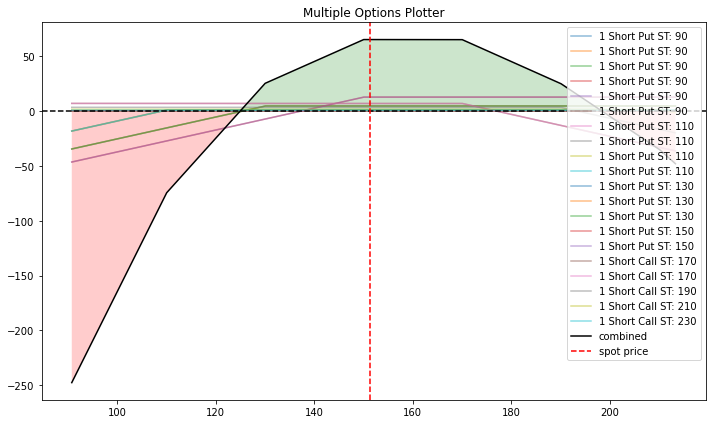

In [32]:
op1={'op_type': 'p', 'strike': 90, 'tr_type': 's', 'op_pr': .30}
op2={'op_type': 'p', 'strike': 110, 'tr_type': 's', 'op_pr': 1.00}
op3={'op_type': 'p', 'strike': 130, 'tr_type': 's', 'op_pr': 4.65}
op4={'op_type': 'p', 'strike': 150, 'tr_type': 's', 'op_pr': 12.75}
op5={'op_type': 'c', 'strike': 170, 'tr_type': 's', 'op_pr': 7.00}
op6={'op_type': 'c', 'strike': 190, 'tr_type': 's', 'op_pr': 3.45}
op7={'op_type': 'c', 'strike': 210, 'tr_type': 's', 'op_pr': 1.70}
op8={'op_type': 'c', 'strike': 230, 'tr_type': 's', 'op_pr': .85}

# Using a live fence as a heage as the op.multiplotter cant do a true delta hedge
op9={'op_type': 'p', 'strike': 150, 'tr_type': 'b', 'op_pr': 12.75}  #hedge
op10={'op_type': 'c', 'strike': 170, 'tr_type': 's', 'op_pr': 7.00}  #hedge


op_list=[op1,op1,op1,op1,op1,op1,op2,op2,op2,op2, op3,op3,op3, op4,op4, op5,op5, op6, op7, op8]

hedged_op_list=[op1,op1,op1,op1,op1,op1,op2,op2,op2,op2, op3,op3,op3, op4,op4, op5,op5, op6, op7, op8, op9, op10]


op.multi_plotter(spot=S,spot_range=(40), op_list=op_list)

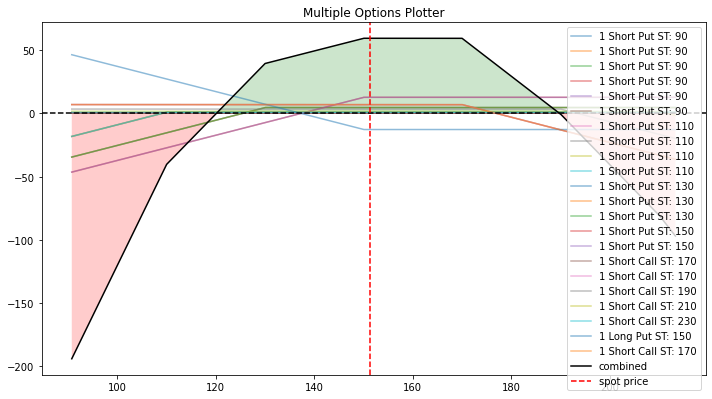

In [31]:
op.multi_plotter(spot=S,spot_range=(40), op_list=hedged_op_list)

#Create Better Graphs with Greek Risks over Price and Time

In [33]:
# To Do, see above title